# Estudo: A evolução da capacidade hospitalar (número de leitos) durante a pandemia de COVID-19

## Objetivos do Estudo
1. Analisar a evolução geral dos leitos hospitalares em Goiás durante a pandemia de COVID-19.
2. Analisar a evolução dos leitos hospitalares comparando diferentes mesoregiôes geográficas de Goiás.
3. Comparar a evolução dos leitos hospitalares por cidade, mostrando a evolução nas principais cidades do estado.
4. Comparar a evolução dos leitos SUS em relação ao total de leitos hospitalares no Estado.
5. Comparar a evolução dos leitos destinados a UTIs em relação ao total de leitos hospitalares em Goiás.
6. Verificar se as melhorias na capacidade hospitalar se mantiveram após as reduções nas quantidaes de casos de COVID-19.

## Autor


Bruno Henrique Conterato

Ciêntista de Dados e Engenheiro de Aprendizado do Máquina

(62) 9 8517-1987

brunoconterato@gmail.com

Trabalha para o CEIA/UFG em projetos de consultoria.

https://github.com/brunoconterato

https://www.linkedin.com/in/brunoconterato/

# 0. Início: importar bibliotecas, inicializar funçoes auxiliares

In [1]:
import pandas as pd
from pathlib import Path
import datetime
import plotly.express as px
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

USE_PLOTLY = False

### Funções auxiliares gerais

In [2]:
def countNones(df: pd.DataFrame):
    return df.isna().sum()

### Funções Auxiliares de dados de município

In [3]:
def getRegiao(data_municipios, cod_municipio_sem_digito, type="meso"):
    if type == "meso":
        key = "Nome_Mesorregião"
    elif type == "micro":
        key = "Nome_Microrregião"
    else:
        raise ValueError("type must be 'meso' or 'micro'")

    return data_municipios[data_municipios["Código Município Sem Dígito"] == cod_municipio_sem_digito][key].values[0]

def getCidade(data_municipios, cod_municipio_sem_digito):
    return data_municipios[data_municipios["Código Município Sem Dígito"] == cod_municipio_sem_digito]["Nome_Município"].values[0]

### Funções auxiliares de dados de saúde

In [4]:
def filter_last_month_of_year(data):
    assert "ANO" in data.columns and "MES" in data.columns, "data must have columns ANO and MES"
    return data.groupby(["ANO"]).apply(lambda x_ano: x_ano[x_ano["MES"] == x_ano["MES"].max()]).reset_index(drop=True)

# 1. Carregar, visualizar e preparar dados

### 1.1 Dados de munícipois (IBGE)

Esses dados serão utilizados para consultar a mesoregião de cada município por meio do seu código, e assim fazer análise dos leitos por mesoregião. 

São 5 as mesoregiões consideradas pelo IBGE para o estado de Goiás: Sul, Leste, Norte, Centro, Noroeste. Goiânia está localizada no Centro goiano.

In [5]:
DATA_MUNICIPIOS_PATH = Path("./data/RELATORIO_DTB_BRASIL_MUNICIPIO.csv")
data_municipios = pd.read_csv(DATA_MUNICIPIOS_PATH, sep=",", encoding="utf-8")
data_municipios = data_municipios[data_municipios["Nome_UF"] == "Goiás"]
data_municipios["Código Município Sem Dígito"] = data_municipios["Código Município Completo"].apply(lambda x: int(str(x)[:-1]))
data_municipios.head()

,UF,Nome_UF,Região Geográfica Intermediária,Nome Região Geográfica Intermediária,Região Geográfica Imediata,Nome Região Geográfica Imediata,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Município,Código Município Completo,Nome_Município,Código Município Sem Dígito
5323,52,Goiás,5201,Goiânia,520001,Goiânia,3,Centro Goiano,10,Goiânia,50,5200050,Abadia de Goiás,520005
5324,52,Goiás,5201,Goiânia,520002,Anápolis,4,Leste Goiano,12,Entorno de Brasília,100,5200100,Abadiânia,520010
5325,52,Goiás,5204,São Luís de Montes Belos - Iporá,520015,Palmeiras de Goiás,5,Sul Goiano,14,Vale do Rio dos Bois,134,5200134,Acreúna,520013
5326,52,Goiás,5201,Goiânia,520003,Inhumas - Itaberaí - Anicuns,3,Centro Goiano,9,Anicuns,159,5200159,Adelândia,520015
5327,52,Goiás,5206,Luziânia - Águas Lindas de Goiás,520022,Flores de Goiás,4,Leste Goiano,12,Entorno de Brasília,175,5200175,Água Fria de Goiás,520017


### 1.2 Dados de leitos em Goiás (CNES)

### Visualização da tabela

In [6]:
DATA_PATH = Path('./data/data_original_2017_to_2022.csv')
data = pd.read_csv(DATA_PATH, index_col="Unnamed: 0")
data

/tmp/ipykernel_34049/1661828260.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_PATH, index_col="Unnamed: 0")


,CNES,CODUFMUN,REGSAUDE,MICR_REG,DISTRSAN,DISTRADM,TPGESTAO,PF_PJ,CPF_CNPJ,NIV_DEP,CNPJ_MAN,ESFERA_A,ATIVIDAD,RETENCAO,NATUREZA,CLIENTEL,TP_UNID,TURNO_AT,NIV_HIER,TERCEIRO,TP_LEITO,CODLEITO,QT_EXIST,QT_CONTR,QT_SUS,QT_NSUS,COMPETEN,NAT_JUR
1,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,2,41,2,0,2,0,201701,2062
2,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,6,34,4,0,3,1,201701,2062
3,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,2,33,6,0,4,2,201701,2062
4,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,4,43,3,0,3,0,201701,2062
5,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,4,10,1,0,1,0,201701,2062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206188,2383691,522205,001,NaN,NaN,NaN,M,3,0,3,44834000107,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,1,3,3,0,3,0,202211,1244
206189,2383691,522205,001,NaN,NaN,NaN,M,3,0,3,44834000107,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,4,10,3,0,3,0,202211,1244
206190,2439883,522220,02,NaN,NaN,NaN,M,3,0,3,37388378000114,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,2,33,7,0,7,0,202211,1244
206191,2439883,522220,02,NaN,NaN,NaN,M,3,0,3,37388378000114,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,4,43,2,0,2,0,202211,1244


### Visualização das colunas da tabela

Ver documento info/IT_CNES_1706.pdf para informações sobrecada coluna.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206192 entries, 1 to 206192
Data columns (total 28 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   CNES      206192 non-null  int64  
 1   CODUFMUN  206192 non-null  int64  
 2   REGSAUDE  126342 non-null  object 
 3   MICR_REG  11221 non-null   object 
 4   DISTRSAN  122 non-null     float64
 5   DISTRADM  2175 non-null    object 
 6   TPGESTAO  206192 non-null  object 
 7   PF_PJ     206192 non-null  int64  
 8   CPF_CNPJ  206192 non-null  int64  
 9   NIV_DEP   206192 non-null  int64  
 10  CNPJ_MAN  206192 non-null  int64  
 11  ESFERA_A  0 non-null       float64
 12  ATIVIDAD  206192 non-null  int64  
 13  RETENCAO  0 non-null       float64
 14  NATUREZA  0 non-null       float64
 15  CLIENTEL  205097 non-null  float64
 16  TP_UNID   206192 non-null  int64  
 17  TURNO_AT  206192 non-null  int64  
 18  NIV_HIER  0 non-null       float64
 19  TERCEIRO  0 non-null       float64
 20  TP_L

### Meses para os quiais temos dados

Todos entre janeiro de 2017 a novembro de 2021

In [8]:
print(data["COMPETEN"].nunique())
periods = data["COMPETEN"].unique()
periods

71


array([201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708,
       201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804,
       201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812,
       201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
       201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004,
       202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
       202101, 202102, 202103, 202104, 202105, 202106, 202107, 202108,
       202109, 202110, 202111, 202112, 202201, 202202, 202203, 202204,
       202205, 202206, 202207, 202208, 202209, 202210, 202211])

### Adição de colunas auxiliares nos dados:
- Ano
- Mês
- Mesoregião
- Cidade

In [9]:
data["COMPETEN"] = data["COMPETEN"].astype(str)
data["ANO"] = data["COMPETEN"].apply(lambda x: x[:4])
data["MES"] = data["COMPETEN"].apply(lambda x: x[4:])
# May take a while (+ 25 secs)
data["NOME_MUNICIPIO"] = data["CODUFMUN"].apply(lambda x: getCidade(data_municipios, x))
# May take a while (+ 25 secs)
data["MESOREGIAO"] = data["CODUFMUN"].apply(lambda x: getRegiao(data_municipios, x, "meso"))
data

,CNES,CODUFMUN,REGSAUDE,MICR_REG,DISTRSAN,DISTRADM,TPGESTAO,PF_PJ,CPF_CNPJ,NIV_DEP,CNPJ_MAN,ESFERA_A,ATIVIDAD,RETENCAO,NATUREZA,CLIENTEL,TP_UNID,TURNO_AT,NIV_HIER,TERCEIRO,TP_LEITO,CODLEITO,QT_EXIST,QT_CONTR,QT_SUS,QT_NSUS,COMPETEN,NAT_JUR,ANO,MES,NOME_MUNICIPIO,MESOREGIAO
1,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,2,41,2,0,2,0,201701,2062,2017,01,Acreúna,Sul Goiano
2,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,6,34,4,0,3,1,201701,2062,2017,01,Acreúna,Sul Goiano
3,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,2,33,6,0,4,2,201701,2062,2017,01,Acreúna,Sul Goiano
4,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,4,43,3,0,3,0,201701,2062,2017,01,Acreúna,Sul Goiano
5,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,4,10,1,0,1,0,201701,2062,2017,01,Acreúna,Sul Goiano
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206188,2383691,522205,001,NaN,NaN,NaN,M,3,0,3,44834000107,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,1,3,3,0,3,0,202211,1244,2022,11,Vicentinópolis,Sul Goiano
206189,2383691,522205,001,NaN,NaN,NaN,M,3,0,3,44834000107,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,4,10,3,0,3,0,202211,1244,2022,11,Vicentinópolis,Sul Goiano
206190,2439883,522220,02,NaN,NaN,NaN,M,3,0,3,37388378000114,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,2,33,7,0,7,0,202211,1244,2022,11,Vila Boa,Leste Goiano
206191,2439883,522220,02,NaN,NaN,NaN,M,3,0,3,37388378000114,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,4,43,2,0,2,0,202211,1244,2022,11,Vila Boa,Leste Goiano


In [10]:
# Visualizando mesoregiões para as quais temos dados
data["MESOREGIAO"].unique()

array(['Sul Goiano', 'Leste Goiano', 'Norte Goiano', 'Centro Goiano',
       'Noroeste Goiano'], dtype=object)

In [11]:
CODIGOS_UTI = [74, 75, 76, 77, 78, 80, 81, 82, 83, 85, 86]
MAP_TIPOS_LEITO = {
    "CIRURGICO": 1,
    "CLINICO": 2,
    "COMPLEMENTARES": 3,    # UTIS e Unidades Intermediárias estão aqui
    "OBSTETRICO": 4,
    "PEDIATRICO": 5,
    "OUTRAS ESPECIALIDADES": 6,
    "HOSPITAL DIA": 7,
}

data_UTI = data[data["CODLEITO"].isin(CODIGOS_UTI)]
data_UTI.head()

,CNES,CODUFMUN,REGSAUDE,MICR_REG,DISTRSAN,DISTRADM,TPGESTAO,PF_PJ,CPF_CNPJ,NIV_DEP,CNPJ_MAN,ESFERA_A,ATIVIDAD,RETENCAO,NATUREZA,CLIENTEL,TP_UNID,TURNO_AT,NIV_HIER,TERCEIRO,TP_LEITO,CODLEITO,QT_EXIST,QT_CONTR,QT_SUS,QT_NSUS,COMPETEN,NAT_JUR,ANO,MES,NOME_MUNICIPIO,MESOREGIAO
74,2361787,520110,3,NaN,NaN,NaN,M,3,1038751000160,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,3,75,20,0,16,4,201701,3999,2017,01,Anápolis,Centro Goiano
75,2361787,520110,3,NaN,NaN,NaN,M,3,1038751000160,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,3,78,10,0,10,0,201701,3999,2017,01,Anápolis,Centro Goiano
76,2361787,520110,3,NaN,NaN,NaN,M,3,1038751000160,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,3,81,10,0,10,0,201701,3999,2017,01,Anápolis,Centro Goiano
107,2442108,520110,3,NaN,NaN,NaN,M,3,1020197000193,3,36975290000136,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,3,78,8,0,6,2,201701,2054,2017,01,Anápolis,Centro Goiano
108,2442108,520110,3,NaN,NaN,NaN,M,3,1020197000193,3,36975290000136,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,3,75,34,0,15,19,201701,2054,2017,01,Anápolis,Centro Goiano


## Comentário sobre os dados disponibilizados pelo CNES

#### Sobre a tabela de dados
- Banco de dados suficientemente abrangente, com informações compiladas mensalmente. Não permite fazer análises em tempos menores, como Mensalmente.
- Dados baixados em 7 de janeiro de 2023, com dados até novembro de 2022. Portanto, não havia-se compilado os dados sobre os leitos referentes a Dezembro de 2022.
- Algumas colunas apresentam grande quantidade de dados nulos (faltantes), como MIC_REG, DISTRADM, DISTRSAN entre outros (ver cálculo de nulos acima). Esses dados náo foram utilizados na nossa análise.

#### Sobre o documento explicativo das colunas da tabela
- O documento explicativo sobre cada coluna pode ser encontrado a partir da raiz do projeto no diretório /info/IT_CNES_1706.pdf
- O documento explica o que representa cada coluna da tabela de maneira satisfatória.
- O documento, no entanto, falha com algumas colunas categóricas, em descrever cada categoria. Por exemplo, valores das colunas TP_LEITO e CODLEITO são representados por números inteiros, mas não foi possível localizar em nenhum local (nem na wiki) a qual categoria cada número corresponde. Por exemplo, não sabemos qual tipo de leito corresponde ao valor 2, nem o que significa o código de leito 3. Para descobrir a que se referem tais valores, elaborei uma estratégia baseada no sistema antigo do CNES (ainda no ar).

#### Como descobrir o que significa cada valor da coluna CODLEITO e TP_LEITO:
1. Abra o sistema antigo (http://cnes2.datasus.gov.br/) na página sobre relatório de Leitos.
2. Selecione um Estado e vai aparecer tabela com os códigos de leito e o respectivos nomes (bem como a quantidade para aquele estado escolhido). Esse valor representa o CODLEITO.
3. Com o CODLEITO, podemos descobrir cada valor de cada TP_LEITO olhando a tabela. Filtre a tabela de dados para determinado valor de CODLEITO (ex.: o CODLEITO 03 Cirurgia Geral é do tipo Cirúrgico, conforme se vê na tabela). Ao fazer isso, os dados restantes na tabela filtrada serão de um TP_LEITO numérico, esse TP_leito (aqui por exemplo vai sobrar o valor 1) corresponderá ao subtítulo da tabela (aqui Cirúrgico). Portanto, o valor 1 de TP_LEITO corresponde ao subtítulo Cirúrgico.

#### Como trabalhar regiões geográficas
- Para trabalhar com regiões geográficas, baixamos dados relativos a municípios a partir do IBGE. Por estes dados, podemos consultar dados do município por meio do seu código, e assim saber a mesoregião (e outras informações) a qual ele pertence.
- O único detalhe é que o código de município da tabela CNES está sem o dígito final, que consta da tabela de municípios do IBGE. Portanto, deve-se encontrar o município sem o último dígito na tabela do IBGE. Para facilitar, criamos uma tabela no IBGE com o código de município sem o dígito final, e a utilizamos para encontrar o município e obter informações sobre ele.

# 2. Análise da evolução da quantidade de Leitos em Goiás (Todos os tipos de Leito)

## Evolução da quantidade de leitos por mês

In [12]:
leitos_por_mes = data.groupby(["COMPETEN"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
leitos_por_mes

,COMPETEN,QT_EXIST,QT_SUS
0,201701,19490,12122
1,201702,19540,12147
2,201703,19593,11939
3,201704,19636,11865
4,201705,19570,11820
...,...,...,...
66,202207,21303,12819
67,202208,21343,12988
68,202209,21315,12942
69,202210,21389,13096


In [13]:
px.line(leitos_por_mes, x="COMPETEN", y=["QT_EXIST", "QT_SUS"], title="Quantidade de leitos por mês", range_y=[0, 24000])

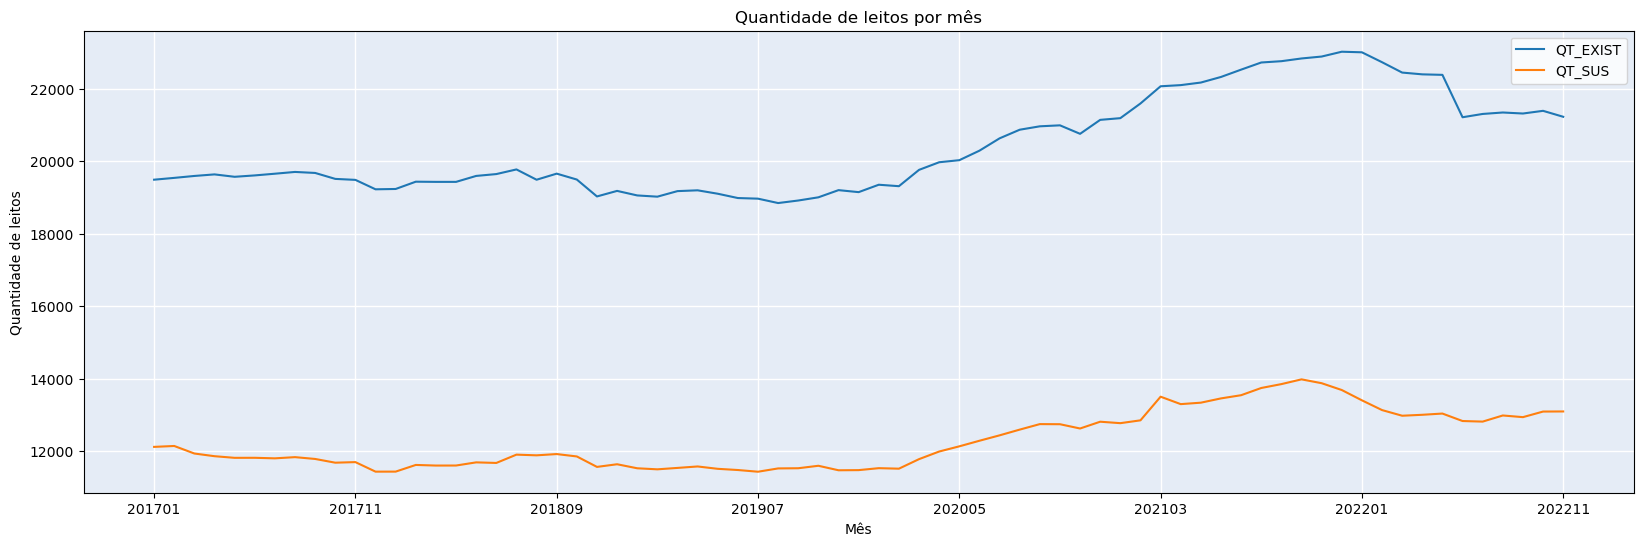

In [14]:
pl = leitos_por_mes.plot(x="COMPETEN", y=["QT_EXIST", "QT_SUS"], title="Quantidade de leitos por mês", figsize=(20, 6), ylabel="Quantidade de leitos", xlabel="Mês")
pl.grid(color="white", linestyle="-", linewidth=1)
pl.set_facecolor("#e5ecf6")

## Evolução da quantidade de Leitos ao final de cada ano

In [15]:
data_ultimo_mes = filter_last_month_of_year(data)
print(data_ultimo_mes["COMPETEN"].unique())
data_ultimo_mes

['201712' '201812' '201912' '202012' '202112' '202211']


,CNES,CODUFMUN,REGSAUDE,MICR_REG,DISTRSAN,DISTRADM,TPGESTAO,PF_PJ,CPF_CNPJ,NIV_DEP,CNPJ_MAN,ESFERA_A,ATIVIDAD,RETENCAO,NATUREZA,CLIENTEL,TP_UNID,TURNO_AT,NIV_HIER,TERCEIRO,TP_LEITO,CODLEITO,QT_EXIST,QT_CONTR,QT_SUS,QT_NSUS,COMPETEN,NAT_JUR,ANO,MES,NOME_MUNICIPIO,MESOREGIAO
0,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,2,33,6,0,4,2,201712,2062,2017,12,Acreúna,Sul Goiano
1,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,4,43,3,0,3,0,201712,2062,2017,12,Acreúna,Sul Goiano
2,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,2,41,2,0,2,0,201712,2062,2017,12,Acreúna,Sul Goiano
3,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,5,45,3,0,3,0,201712,2062,2017,12,Acreúna,Sul Goiano
4,2335506,520013,15,NaN,NaN,NaN,M,3,269860000125,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,6,34,4,0,3,1,201712,2062,2017,12,Acreúna,Sul Goiano
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17434,2383691,522205,001,NaN,NaN,NaN,M,3,0,3,44834000107,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,1,3,3,0,3,0,202211,1244,2022,11,Vicentinópolis,Sul Goiano
17435,2383691,522205,001,NaN,NaN,NaN,M,3,0,3,44834000107,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,4,10,3,0,3,0,202211,1244,2022,11,Vicentinópolis,Sul Goiano
17436,2439883,522220,02,NaN,NaN,NaN,M,3,0,3,37388378000114,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,2,33,7,0,7,0,202211,1244,2022,11,Vila Boa,Leste Goiano
17437,2439883,522220,02,NaN,NaN,NaN,M,3,0,3,37388378000114,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,4,43,2,0,2,0,202211,1244,2022,11,Vila Boa,Leste Goiano


In [16]:
leitos_ultimo_mes = data_ultimo_mes.groupby(["COMPETEN", "ANO"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
px.bar(leitos_ultimo_mes, x="ANO", y=["QT_EXIST", "QT_SUS"], title="Quantidade de leitos no último mês do ano", barmode="group")

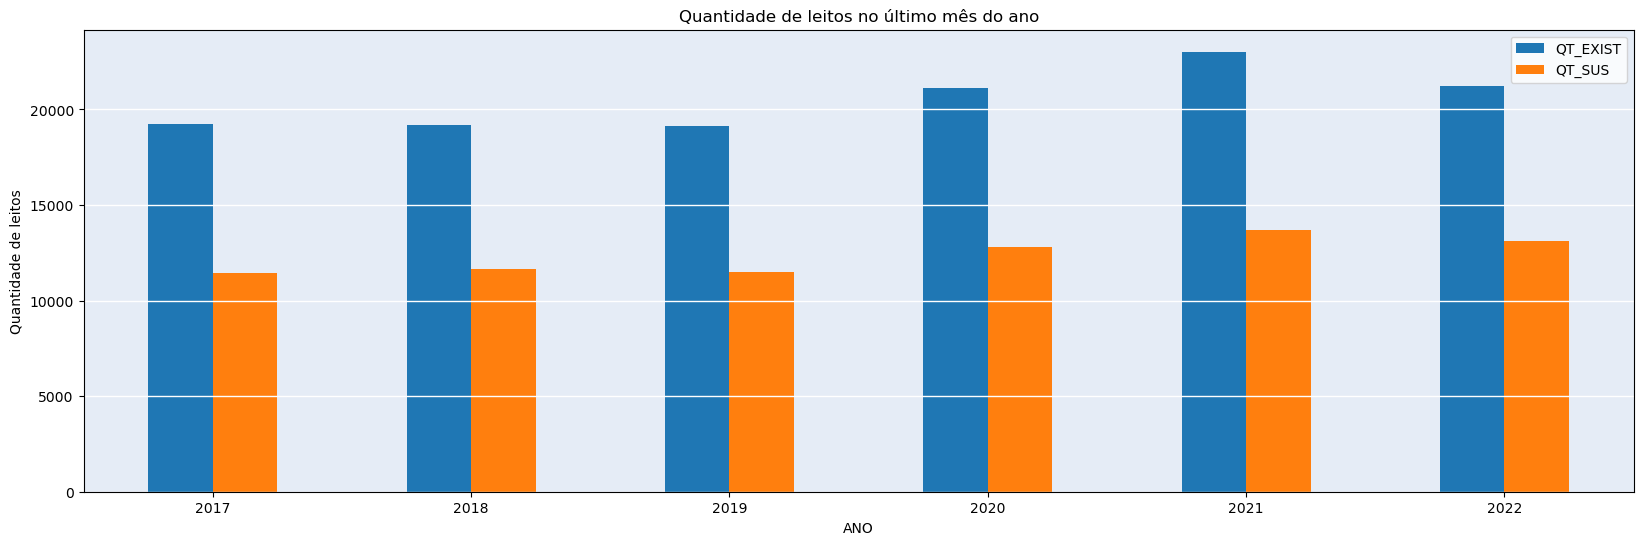

In [17]:
pl = leitos_ultimo_mes.plot(x="ANO", y=["QT_EXIST", "QT_SUS"], title="Quantidade de leitos no último mês do ano", kind="bar", figsize=(20, 6), rot=0, ylabel="Quantidade de leitos")
pl.grid(color="white", linestyle="-", linewidth=1, axis="y")
pl.set_facecolor("#e5ecf6")

## Evolução da quantidade de Leitos por Mesoregião

### Total

In [18]:
leitos_por_regiao = data.groupby(["COMPETEN", "MESOREGIAO"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()

In [19]:

px.line(leitos_por_regiao, x="COMPETEN", y="QT_EXIST", color="MESOREGIAO", title="Quantidade de leitos totais por mesoregião", range_y=[0, 16000])

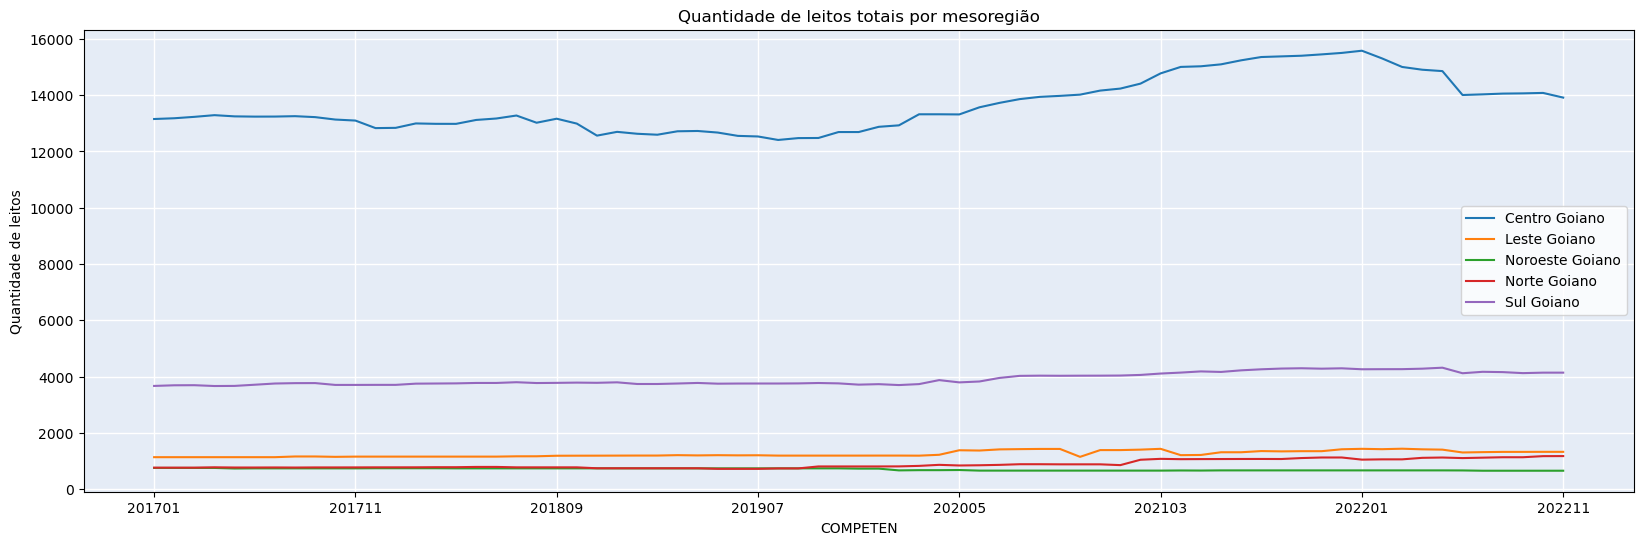

In [20]:
fig, ax = plt.subplots()

for key, grp in leitos_por_regiao.groupby(['MESOREGIAO']):
    ax = grp.plot(ax=ax, kind='line', x='COMPETEN', y='QT_EXIST', label=key, figsize=(20, 6), ylabel="Quantidade de leitos", title="Quantidade de leitos totais por mesoregião")

ax.grid(color="white", linestyle="-", linewidth=1)
ax.set_facecolor("#e5ecf6")
plt.legend(loc='best')

In [21]:
data_ultimo_mes_por_meso = data.groupby(["COMPETEN", "MESOREGIAO", "ANO", "MES"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
data_ultimo_mes_por_meso = filter_last_month_of_year(data_ultimo_mes_por_meso)

In [22]:
px.bar(data_ultimo_mes_por_meso, x="ANO", y="QT_EXIST", color="MESOREGIAO", title="Quantidade de leitos totais por mesoregião no final de cada ano", barmode="group")

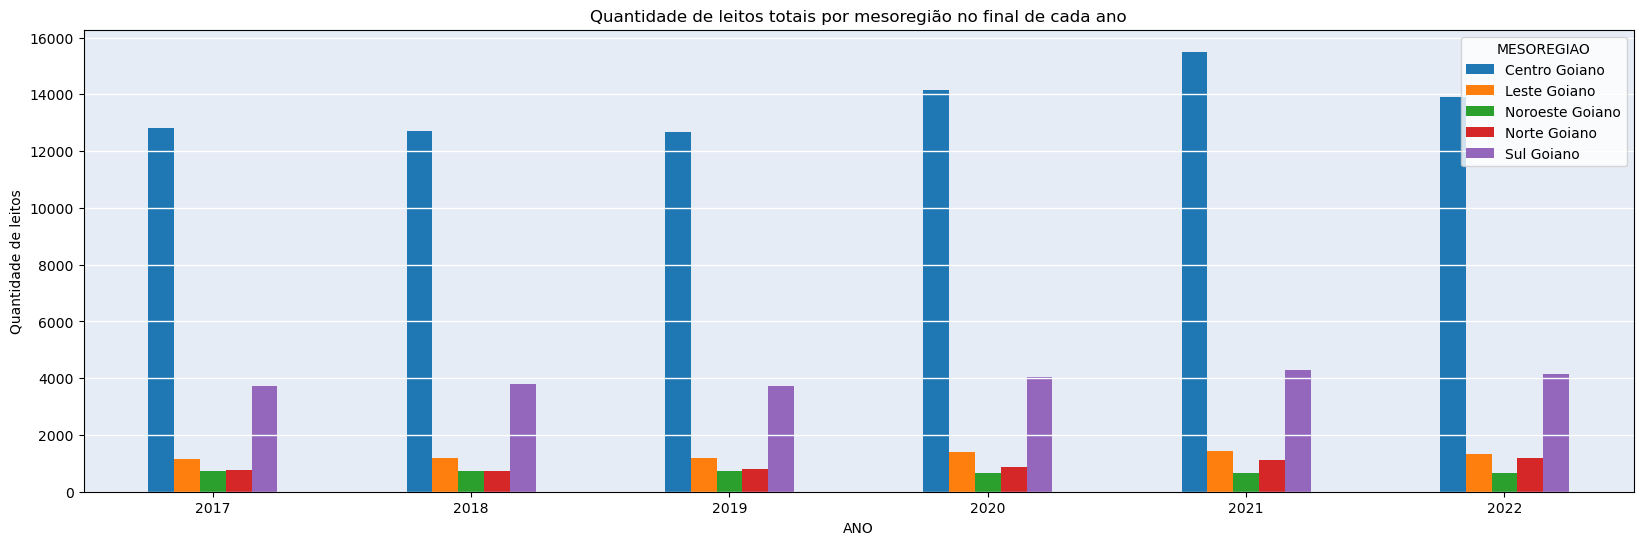

In [23]:
# data_for_bars = data_ultimo_mes_por_meso.groupby(["ANO", "MESOREGIAO"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
data_for_bars = data_ultimo_mes_por_meso.pivot(index="ANO", columns="MESOREGIAO", values="QT_EXIST")
pl = data_for_bars.plot(kind="bar", figsize=(20, 6), rot=0, ylabel="Quantidade de leitos", title="Quantidade de leitos totais por mesoregião no final de cada ano")

# set grid in the background
pl.grid(color="white", linestyle="-", linewidth=1, axis="y", zorder=0)
pl.set_facecolor("#e5ecf6")

### Sus

In [24]:
px.line(leitos_por_regiao, x="COMPETEN", y="QT_SUS", color="MESOREGIAO", title="Quantidade de leitos SUS por mesoregião", range_y=[0, 10000])

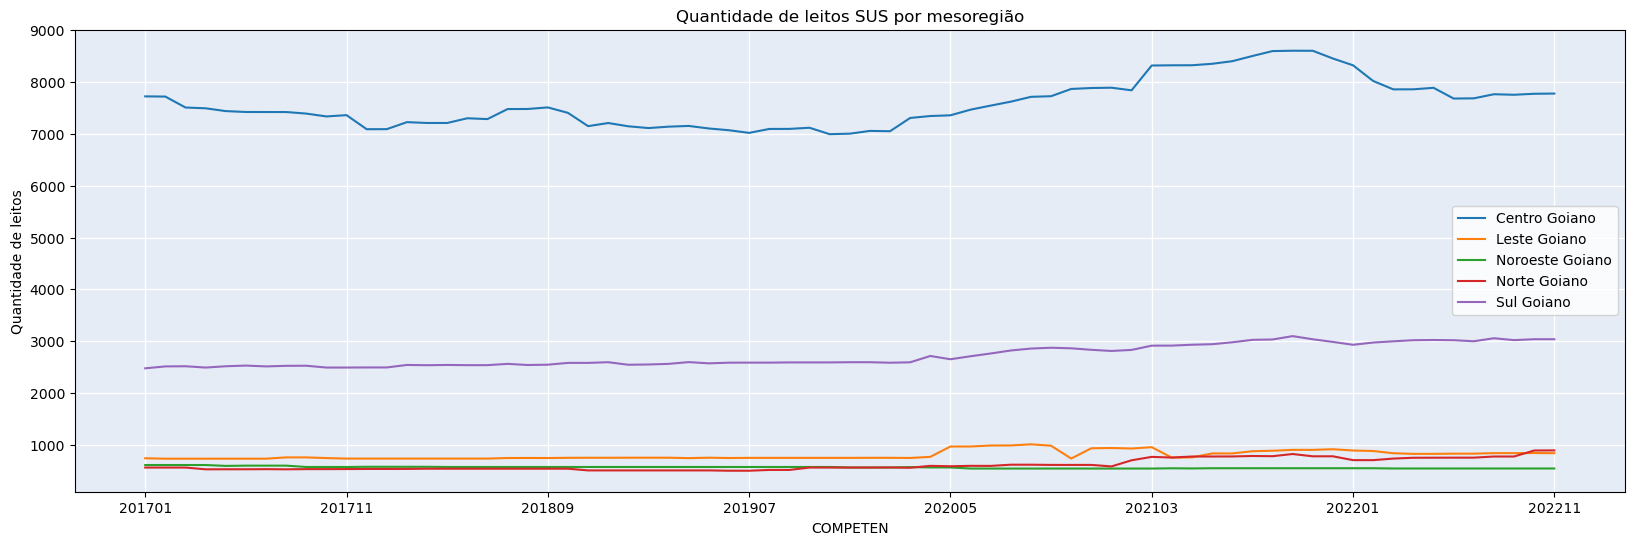

In [25]:
fig, ax = plt.subplots()

for key, grp in leitos_por_regiao.groupby(['MESOREGIAO']):
    ax = grp.plot(ax=ax, kind='line', x='COMPETEN', y='QT_SUS', label=key, figsize=(20, 6), ylabel="Quantidade de leitos", title="Quantidade de leitos SUS por mesoregião")

ax.grid(color="white", linestyle="-", linewidth=1)
ax.set_facecolor("#e5ecf6")
plt.legend(loc='best')

In [26]:
px.bar(data_ultimo_mes_por_meso, x="ANO", y="QT_SUS", color="MESOREGIAO", title="Quantidade de leitos SUS por mesoregião", barmode="group")

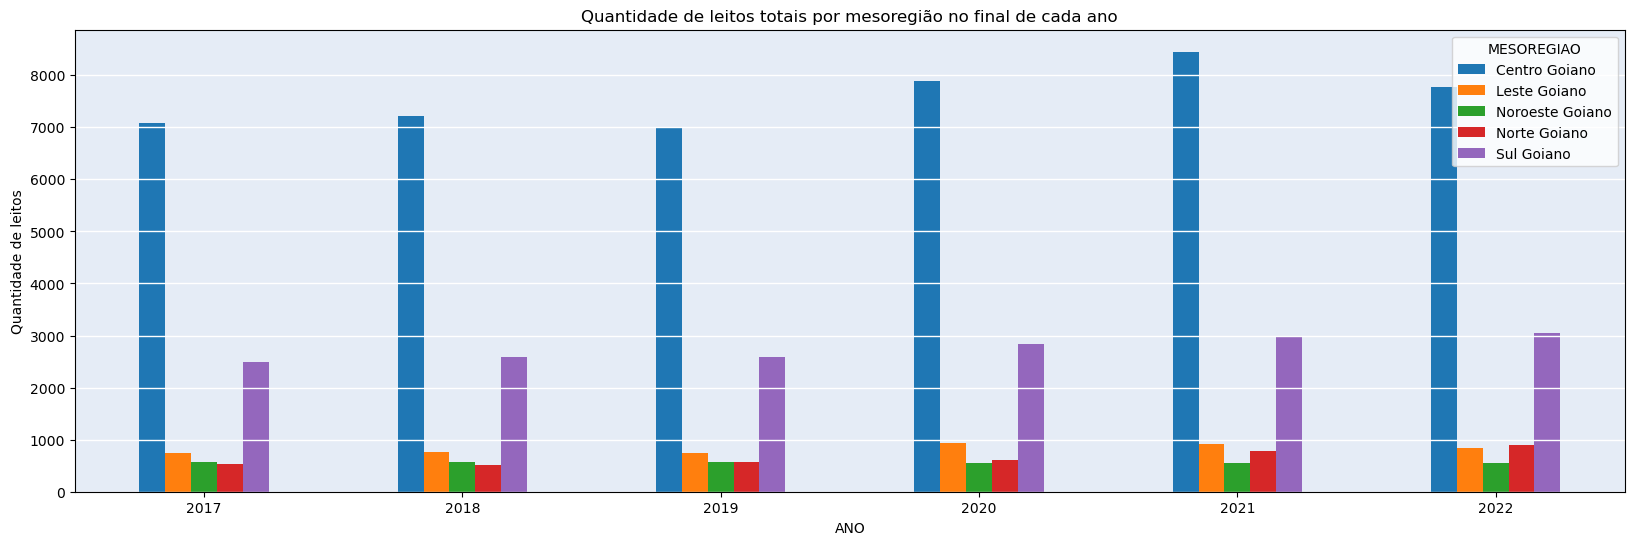

In [27]:
# data_for_bars = data_ultimo_mes_por_meso.groupby(["ANO", "MESOREGIAO"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
data_for_bars = data_ultimo_mes_por_meso.pivot(index="ANO", columns="MESOREGIAO", values="QT_SUS")
pl = data_for_bars.plot(kind="bar", figsize=(20, 6), rot=0, ylabel="Quantidade de leitos", title="Quantidade de leitos totais por mesoregião no final de cada ano")

# set grid in the background
pl.grid(color="white", linestyle="-", linewidth=1, axis="y", zorder=0)
pl.set_facecolor("#e5ecf6")

## Evolução da quantidade de Leitos por Cidade

- A fim de simplificar a visualização, vamos considerar apenas as 10 cidades com mais leitos em dezembro de 2021

In [28]:
leitos_por_cidade = data.groupby(["COMPETEN", "NOME_MUNICIPIO", "ANO", "MES"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
leitos_por_cidade_fim_ano = filter_last_month_of_year(leitos_por_cidade)


In [29]:
leitos_fim_2021_por_cidade = leitos_por_cidade_fim_ano[leitos_por_cidade_fim_ano["ANO"] == "2021"]
leitos_fim_2021_por_cidade.sort_values(by="QT_EXIST", ascending=False).head(10)

,COMPETEN,NOME_MUNICIPIO,ANO,MES,QT_EXIST,QT_SUS
830,202112,Goiânia,2021,12,9306,4161
763,202112,Aparecida de Goiânia,2021,12,1700,1337
762,202112,Anápolis,2021,12,1364,748
907,202112,Rio Verde,2021,12,648,400
932,202112,Trindade,2021,12,555,444
938,202112,Uruaçu,2021,12,402,252
792,202112,Catalão,2021,12,397,218
796,202112,Ceres,2021,12,363,146
850,202112,Itumbiara,2021,12,284,167
827,202112,Goianésia,2021,12,283,195


In [30]:
cidades_com_mais_leitos_dez_2021 = leitos_fim_2021_por_cidade.sort_values(by="QT_EXIST", ascending=False).head(10)["NOME_MUNICIPIO"].unique()
print(cidades_com_mais_leitos_dez_2021)
leitos_por_cidade_fim_ano = leitos_por_cidade_fim_ano[leitos_por_cidade_fim_ano["NOME_MUNICIPIO"].isin(cidades_com_mais_leitos_dez_2021)]
leitos_por_cidade_fim_ano.head()

['Goiânia' 'Aparecida de Goiânia' 'Anápolis' 'Rio Verde' 'Trindade'
 'Uruaçu' 'Catalão' 'Ceres' 'Itumbiara' 'Goianésia']


,COMPETEN,NOME_MUNICIPIO,ANO,MES,QT_EXIST,QT_SUS
8,201712,Anápolis,2017,12,1155,618
9,201712,Aparecida de Goiânia,2017,12,871,666
38,201712,Catalão,2017,12,347,226
42,201712,Ceres,2017,12,312,136
73,201712,Goianésia,2017,12,271,172


In [31]:
px.bar(leitos_por_cidade_fim_ano, x="ANO", y="QT_EXIST", color="NOME_MUNICIPIO", title="Quantidade de leitos totais por cidade no final de cada ano", barmode="group")

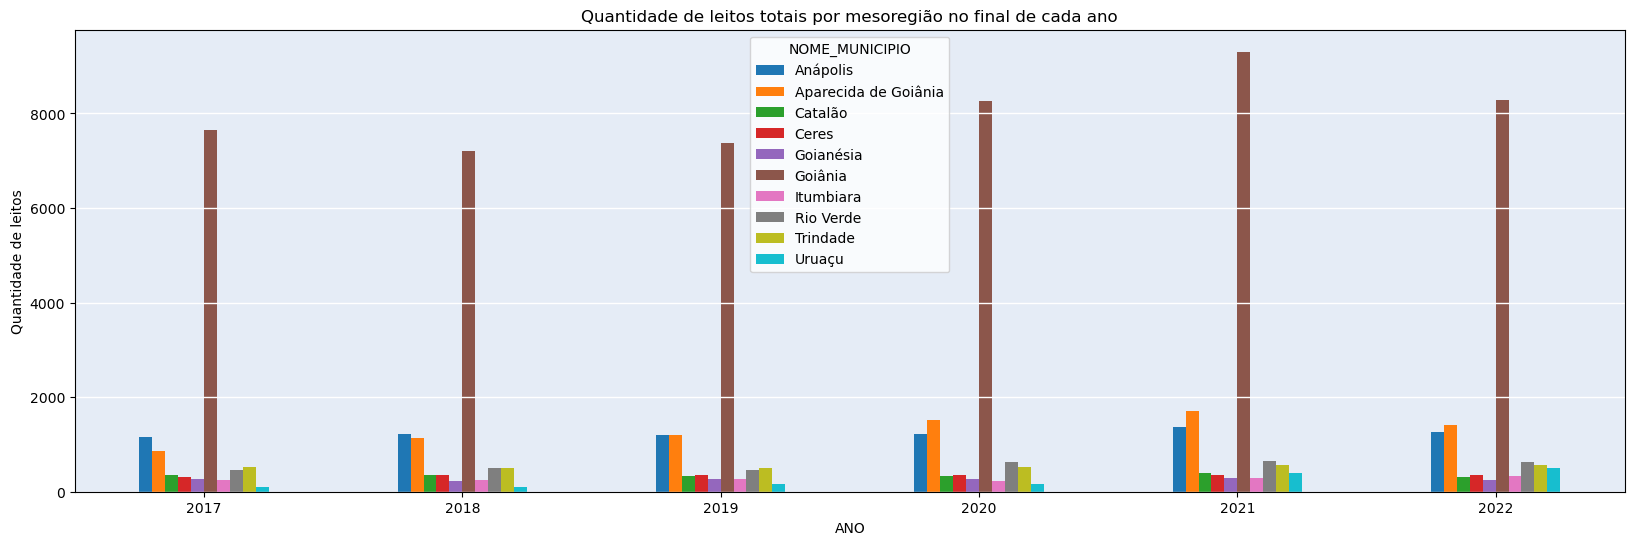

In [32]:
# data_for_bars = data_ultimo_mes_por_meso.groupby(["ANO", "MESOREGIAO"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
data_for_bars = leitos_por_cidade_fim_ano.pivot(index="ANO", columns="NOME_MUNICIPIO", values="QT_EXIST")
pl = data_for_bars.plot(kind="bar", figsize=(20, 6), rot=0, ylabel="Quantidade de leitos", title="Quantidade de leitos totais por mesoregião no final de cada ano")

# set grid in the background
pl.grid(color="white", linestyle="-", linewidth=1, axis="y", zorder=0)
pl.set_facecolor("#e5ecf6")

## Conclusões acerca da quantidade de leitos em Goiás e o efeito da Pandemia de Covid-19

#### Observações no estudo de evolução da quantidade de leitos em Goiás
- Durante o período analisado (2017 a 2022), houve aumento de aproximadamente 8,9% na quantidade total de leitos em Goiás passando de 19.490 para 21.225 leitos. O Aumento no SUS foi de 8,1% durante todo o período, passando de 12.122 para 13.099 leitos. Portanto, durante esse período, o número de leitos não SUS aumentou proporcionalmente mais em quantidade em relação aos leitos SUS.
- A Pandemia foi oficialmente declarada pela OMS em março de 2020, quando o número de leitos em Goiás foi de 19.761 totais e 11.784 SUS. A partir de então houve um aumento de 7,4% na quantidade total de leitos em Goiás até Novembro de 2022. O Aumento no SUS foi de 11,2% durante o mesmo período. O aumento na quantidade absoluta de leitos foi, portanto, proporcionalmente maior dentre os Leitos do SUS do que os que dentre os que não são do SUS desde que foi decretada a Pandemia pela OMS.
- A quantidade máxima no número de leitos totais foi verificada em dezembro de 2021 (23.019 leitos). Já No Sus, a quantidade máxima foi verificada em Outubro de 2021 (13.984 leitos). Isso significam aumentos percentuais de 16,5% e 18,7%, respectivamente, nos leitos totais e nos Leitos pelo SUS em relação a Março de 2020, quando foi decretada Pandemia pela OMS. Mais uma vez, nota-se no auge que os leitos SUS aumentaram proporcionalmente mais em quantidade em relação aos leitos não SUS desde que foi decretada a Pandemia pela OMS.

#### Observação no estudo de evolução da quantidade de leitos distribuído por Mesoregião
- Verifica-se, desde o início do estudo, grandes disparidades regionais na quantidade de leitos em Goiás. A Mesoregião Norte, por exemplo, possui apenas 3,1% da quantidade total de leitos em Goiás em novembro de 2022 (659 leitos), enquanto a Mesoregião Centro possui 65,6% da quantidade total de leitos em Goiás em novembro de 2022 (13.914 leitos). A Mesoregião Sul possui 19,5% da quantidade total de leitos em Goiás (4.143 leitos). A Mesoregião Leste possui 6,3% da quantidade total de leitos em Goiás. A Mesoregião Norte possui 5,5% da quantidade total de leitos em Goiás. Portanto, a maioria dos leitos totais se encontra em cidades localizadas na região Centro de Goiás, onde localizam-se cidades como Goiânia, Aparecida de Goiânia, Anápolis e Senador Canedo.
- No auge da quantidade de leitos totais, ocorrida em janeiro de 2022, a Mesoregião Centro possuía 67,7% da quantidade total de leitos em Goiás (15.579 leitos), enquanto a Mesoregião Sul possuía 18,5% da quantidade total de leitos em Goiás (4.263 leitos). A Mesoregião Leste possuía 6,2% da quantidade total de leitos em Goiás. A Mesoregião Norte possuía 4,6% da quantidade total de leitos em Goiás. A região Noroeste possuía 2,9% do total de leitos em Goiás (671 leitos) Portanto, a maioria dos leitos totais se encontram em cidades localizadas na região Centro de Goiás, também no auge da Pandemia.
- Desde que foi decretada a Pandemia pelo OMS, em março de 2020, a Mesoregião Centro passou de 13.321 leitos totais para 15.579 leitos totais no auge da pandemia, um aumento de 17,0% (ou 2258 novos leitos). Foi a região que mais ganhou leitos como consequência da Pandemia de Covd-19 em GOiás.

#### Observação no estudo de evolução da quantidade de leitos distribuído por Cidade
- Verifica-se que Goiânia é foi a cidade com maior quantidade de leitos durante todo o período analisado, seguida por Aparecida de Goiânia e Anápolis. Goiânia possuía 39,0% dos leitos totais de GOiás ao final do período de análise, enquanto aparecida de Goiânia possuía 6,6% do total. Destacam-se na quantidade total de leitos, além dessas três principais cidades: Catalão, Ceres, Rio Verde, Jataí, Goianésia, Itumbiara, Trindade e Uruaçu.

# 3. Análise da evolução da quantidade de Leitos de UTI em Goiás

## Evolução da quantidade de leitos por mês

In [33]:
leitos_por_mes = data_UTI.groupby(["COMPETEN"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
leitos_por_mes

,COMPETEN,QT_EXIST,QT_SUS
0,201701,1355,722
1,201702,1375,722
2,201703,1414,728
3,201704,1456,728
4,201705,1456,728
...,...,...,...
66,202207,2081,1019
67,202208,2114,1019
68,202209,2115,1019
69,202210,2107,1020


In [34]:
px.line(leitos_por_mes, x="COMPETEN", y=["QT_EXIST", "QT_SUS"], title="Quantidade de leitos de UTI por mês", range_y=[0, 2400])

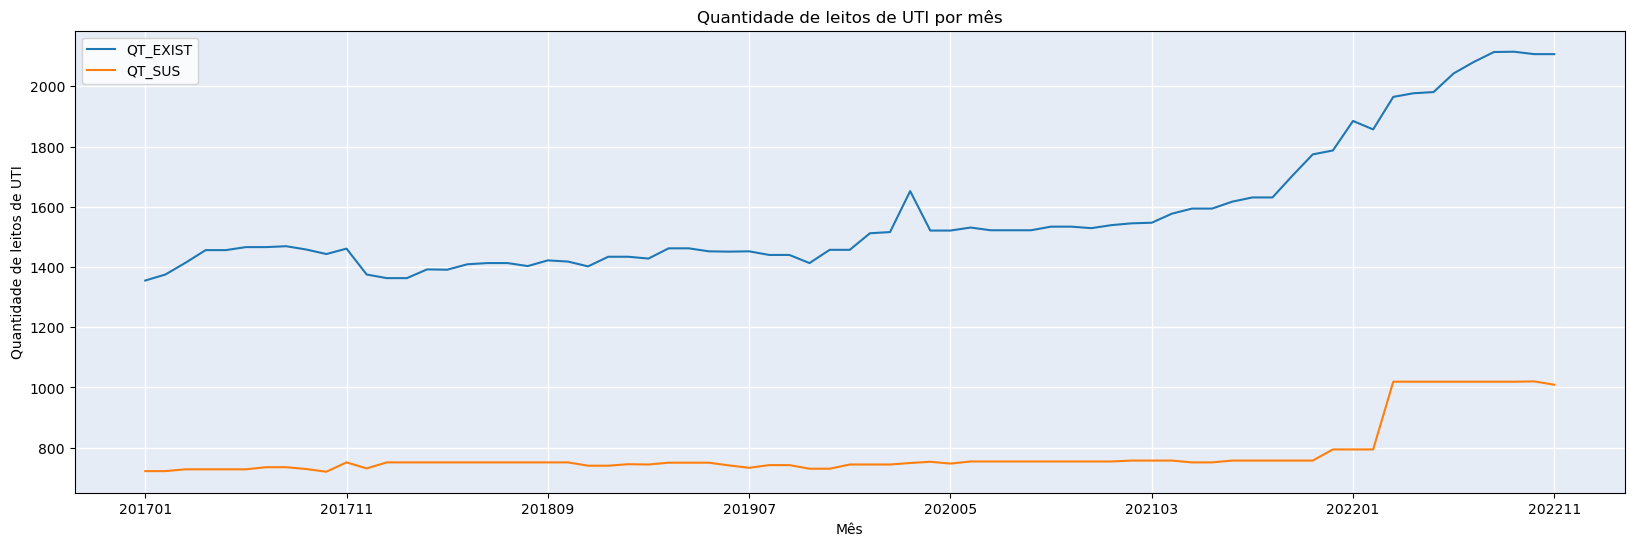

In [35]:
pl = leitos_por_mes.plot(x="COMPETEN", y=["QT_EXIST", "QT_SUS"], title="Quantidade de leitos de UTI por mês", figsize=(20, 6), ylabel="Quantidade de leitos de UTI", rot=0, xlabel="Mês")
pl.grid(color="white", linestyle="-", linewidth=1)
pl.set_facecolor("#e5ecf6")

## Evolução da quantidade de Leitos ao final de cada ano

In [36]:
data_ultimo_mes = filter_last_month_of_year(data_UTI)
print(data_ultimo_mes["COMPETEN"].unique())
data_ultimo_mes

['201712' '201812' '201912' '202012' '202112' '202211']


,CNES,CODUFMUN,REGSAUDE,MICR_REG,DISTRSAN,DISTRADM,TPGESTAO,PF_PJ,CPF_CNPJ,NIV_DEP,CNPJ_MAN,ESFERA_A,ATIVIDAD,RETENCAO,NATUREZA,CLIENTEL,TP_UNID,TURNO_AT,NIV_HIER,TERCEIRO,TP_LEITO,CODLEITO,QT_EXIST,QT_CONTR,QT_SUS,QT_NSUS,COMPETEN,NAT_JUR,ANO,MES,NOME_MUNICIPIO,MESOREGIAO
0,2361787,520110,3,NaN,NaN,NaN,M,3,1038751000160,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,3,75,20,0,16,4,201712,3999,2017,12,Anápolis,Centro Goiano
1,2361787,520110,3,NaN,NaN,NaN,M,3,1038751000160,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,3,81,10,0,10,0,201712,3999,2017,12,Anápolis,Centro Goiano
2,2361787,520110,3,NaN,NaN,NaN,M,3,1038751000160,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,3,78,10,0,10,0,201712,3999,2017,12,Anápolis,Centro Goiano
3,2442108,520110,3,NaN,NaN,NaN,M,3,36975290000136,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,3,78,8,0,6,2,201712,3069,2017,12,Anápolis,Centro Goiano
4,2442108,520110,3,NaN,NaN,NaN,M,3,36975290000136,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,3,75,34,0,15,19,201712,3069,2017,12,Anápolis,Centro Goiano
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,2570777,522045,1,NaN,NaN,NaN,M,3,2485436000143,1,0,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,3,75,14,0,8,6,202211,2062,2022,11,Senador Canedo,Centro Goiano
798,5095808,522140,1,NaN,NaN,NaN,E,3,0,3,2529964000157,NaN,4,NaN,NaN,3.0,5,6,NaN,NaN,3,75,10,0,0,10,202211,1023,2022,11,Trindade,Centro Goiano
799,547484,522160,NaN,NaN,NaN,NaN,E,3,0,3,2529964000157,NaN,4,NaN,NaN,2.0,5,6,NaN,NaN,3,78,10,0,10,0,202211,1023,2022,11,Uruaçu,Norte Goiano
800,547484,522160,NaN,NaN,NaN,NaN,E,3,0,3,2529964000157,NaN,4,NaN,NaN,2.0,5,6,NaN,NaN,3,81,10,0,0,10,202211,1023,2022,11,Uruaçu,Norte Goiano


In [37]:
leitos_ultimo_mes = data_ultimo_mes.groupby(["COMPETEN", "ANO"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()

In [38]:

px.bar(leitos_ultimo_mes, x="ANO", y=["QT_EXIST", "QT_SUS"], title="Quantidade de leitos de UTI no último mês do ano", barmode="group")

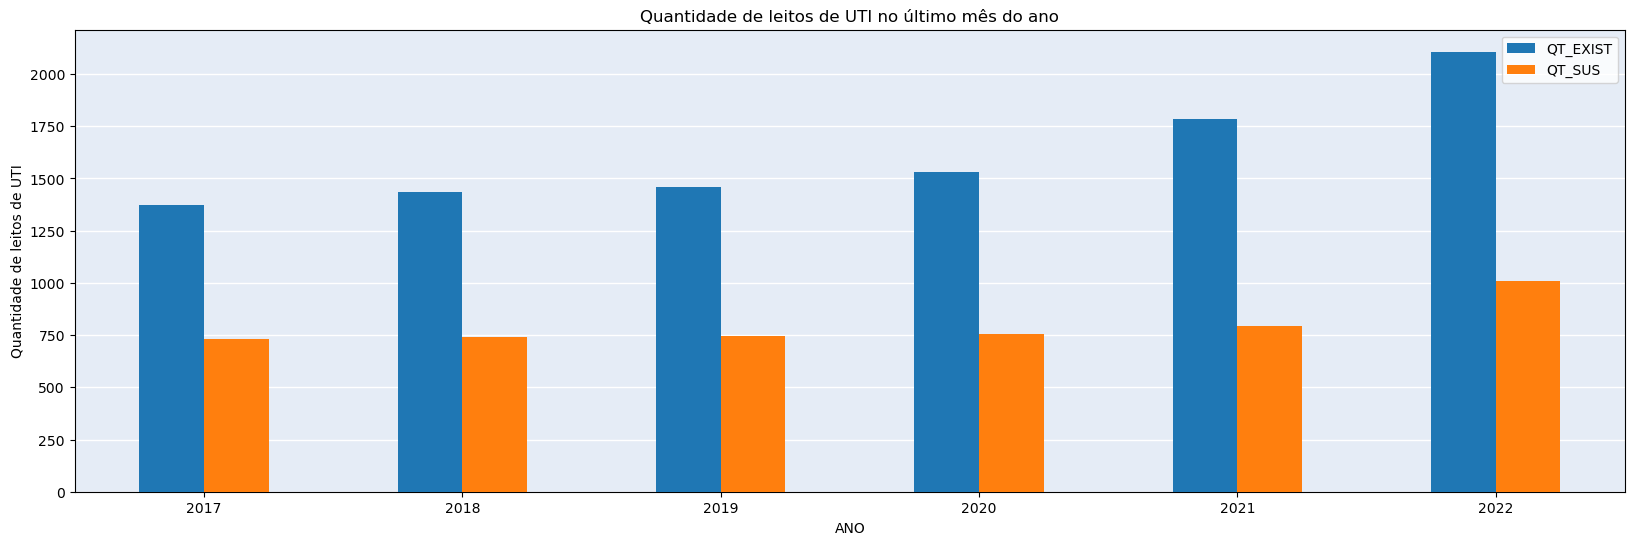

In [39]:
pl = leitos_ultimo_mes.plot(x="ANO", y=["QT_EXIST", "QT_SUS"], title="Quantidade de leitos de UTI no último mês do ano", kind="bar", figsize=(20, 6), rot=0, ylabel="Quantidade de leitos de UTI", zorder=3)
pl.grid(color="white", linestyle="-", linewidth=1, axis="y", zorder=0)
pl.set_facecolor("#e5ecf6")

## Evolução da quantidade de Leitos por Mesoregião

### Total

In [40]:
leitos_por_regiao = data_UTI.groupby(["COMPETEN", "MESOREGIAO"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
px.line(leitos_por_regiao, x="COMPETEN", y="QT_EXIST", color="MESOREGIAO", title="Quantidade de leitos totais de UTI por mesoregião", range_y=[0, 2000])

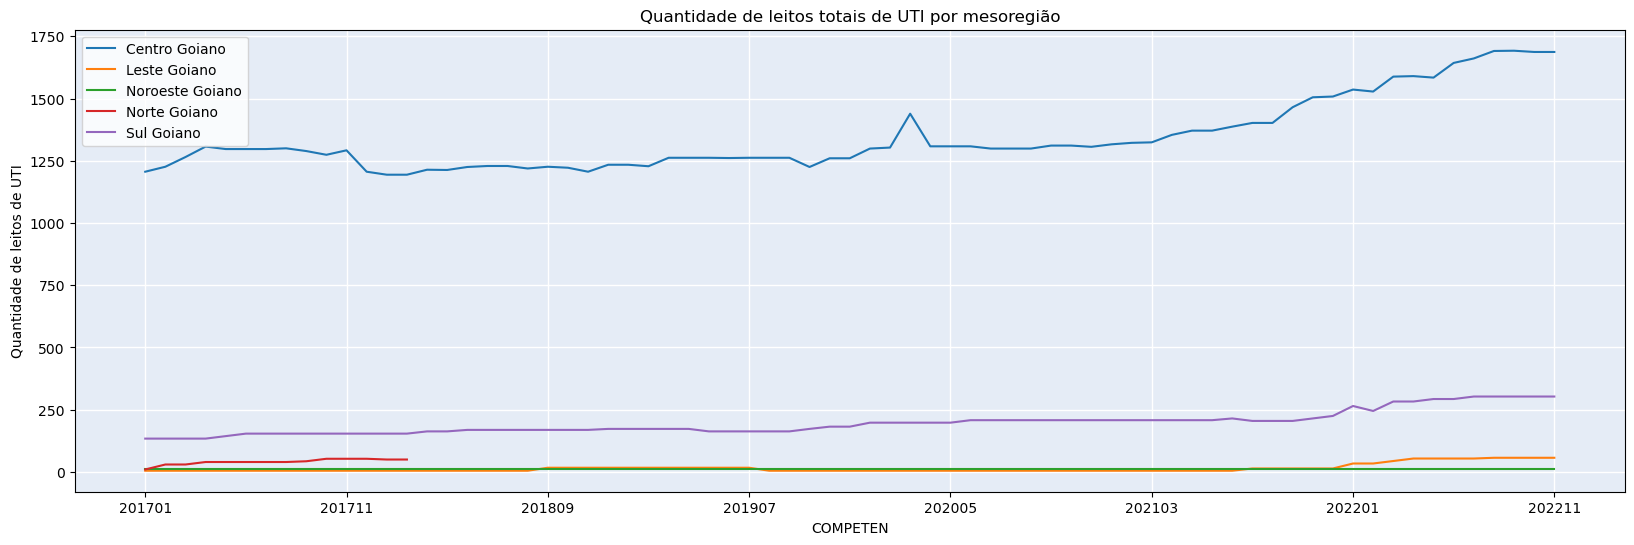

In [41]:
fig, ax = plt.subplots()

for key, grp in leitos_por_regiao.groupby(['MESOREGIAO']):
    ax = grp.plot(ax=ax, kind='line', x='COMPETEN', y='QT_EXIST', label=key, figsize=(20, 6), ylabel="Quantidade de leitos de UTI", title="Quantidade de leitos totais de UTI por mesoregião")

ax.grid(color="white", linestyle="-", linewidth=1)
ax.set_facecolor("#e5ecf6")
plt.legend(loc='best')

In [42]:
data_ultimo_mes_por_meso = data_UTI.groupby(["COMPETEN", "MESOREGIAO", "ANO", "MES"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
data_ultimo_mes_por_meso = filter_last_month_of_year(data_ultimo_mes_por_meso)

In [43]:
px.bar(data_ultimo_mes_por_meso, x="ANO", y="QT_EXIST", color="MESOREGIAO", title="Quantidade de leitos totais por mesoregião no final de cada ano", barmode="group")

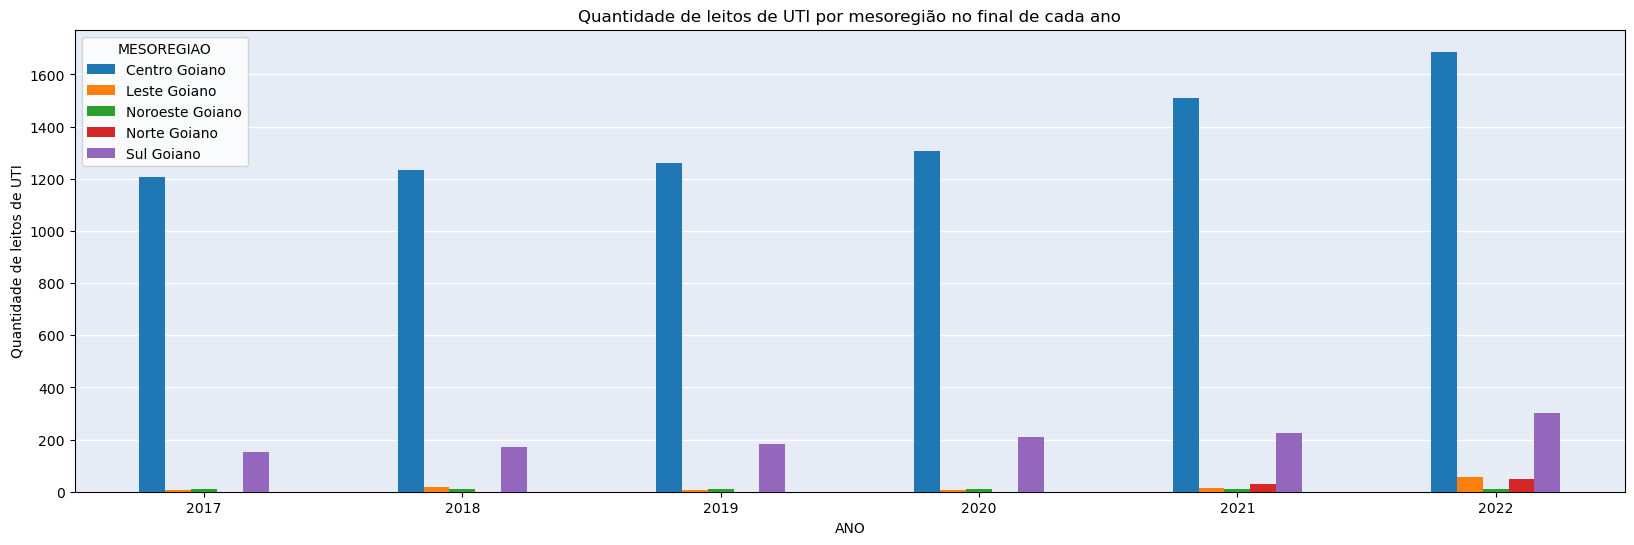

In [44]:
# data_for_bars = data_ultimo_mes_por_meso.groupby(["ANO", "MESOREGIAO"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
data_for_bars = data_ultimo_mes_por_meso.pivot(index="ANO", columns="MESOREGIAO", values="QT_EXIST")
pl = data_for_bars.plot(kind="bar", figsize=(20, 6), rot=0, ylabel="Quantidade de leitos de UTI", title="Quantidade de leitos de UTI por mesoregião no final de cada ano", zorder=3)

# set grid in the background
pl.grid(color="white", linestyle="-", linewidth=1, axis="y", zorder=0)
pl.set_facecolor("#e5ecf6")

### Sus

In [45]:
px.line(leitos_por_regiao, x="COMPETEN", y="QT_SUS", color="MESOREGIAO", title="Quantidade de leitos SUS por mesoregião", range_y=[0, 1000])

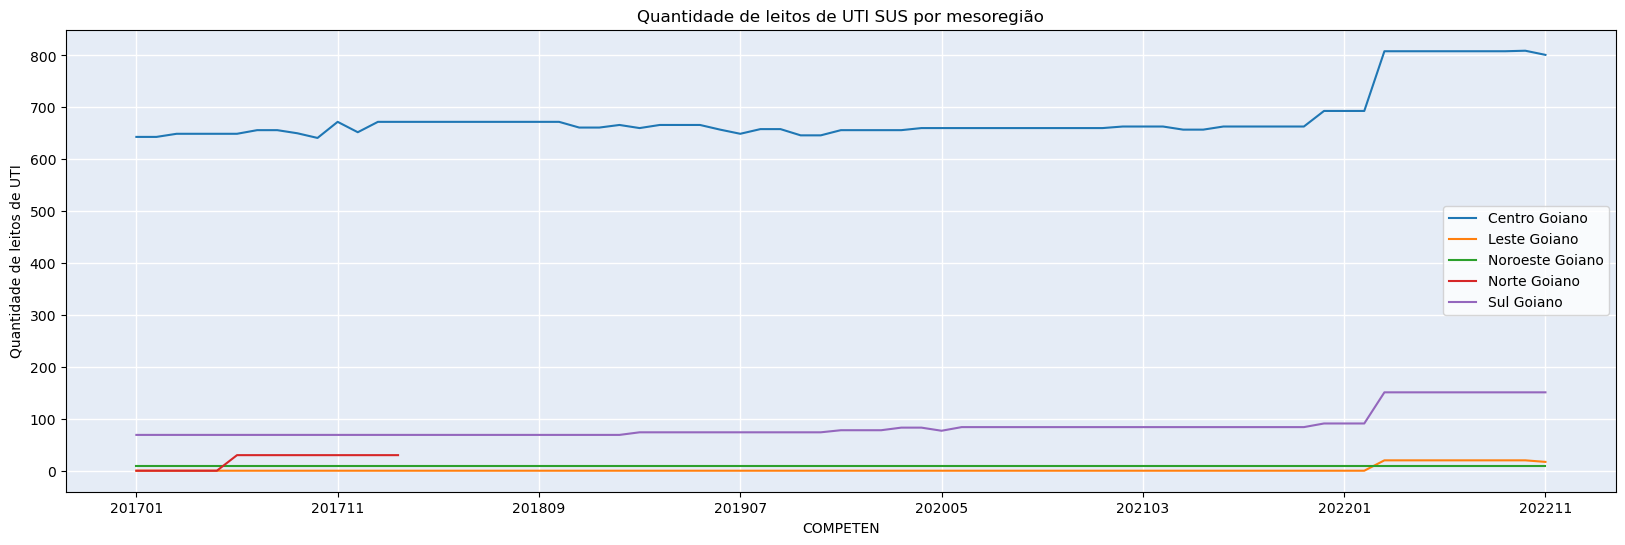

In [46]:
fig, ax = plt.subplots()

for key, grp in leitos_por_regiao.groupby(['MESOREGIAO']):
    ax = grp.plot(ax=ax, kind='line', x='COMPETEN', y='QT_SUS', label=key, figsize=(20, 6), ylabel="Quantidade de leitos de UTI", title="Quantidade de leitos de UTI SUS por mesoregião")

ax.grid(color="white", linestyle="-", linewidth=1)
ax.set_facecolor("#e5ecf6")
plt.legend(loc='best')

In [47]:
px.bar(data_ultimo_mes_por_meso, x="ANO", y="QT_SUS", color="MESOREGIAO", title="Quantidade de leitos SUS por mesoregião", barmode="group")

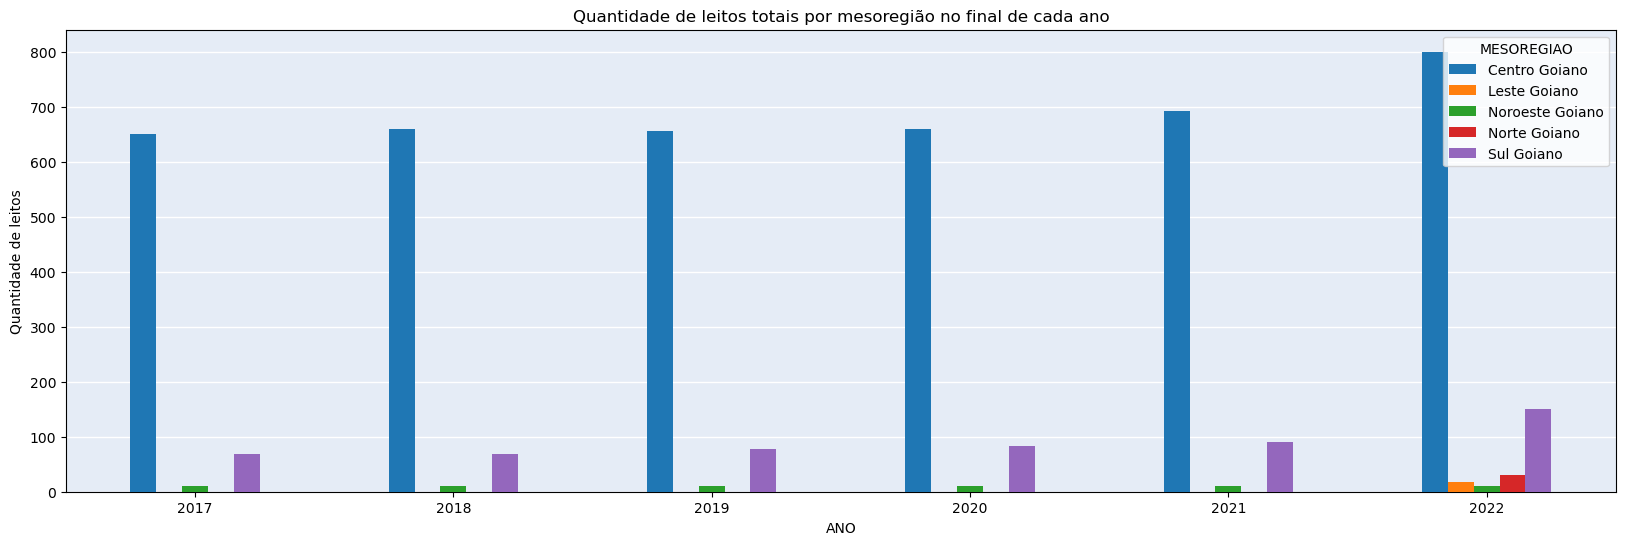

In [48]:
# data_for_bars = data_ultimo_mes_por_meso.groupby(["ANO", "MESOREGIAO"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
data_for_bars = data_ultimo_mes_por_meso.pivot(index="ANO", columns="MESOREGIAO", values="QT_SUS")
pl = data_for_bars.plot(kind="bar", figsize=(20, 6), rot=0, ylabel="Quantidade de leitos", title="Quantidade de leitos totais por mesoregião no final de cada ano", zorder=3)

# set grid in the background
pl.grid(color="white", linestyle="-", linewidth=1, axis="y", zorder=0)
pl.set_facecolor("#e5ecf6")

## Evolução da quantidade de Leitos por Cidade

- A fim de simplificar a visualização, vamos considerar apenas as 10 cidades com mais leitos em dezembro de 2021

In [49]:
leitos_por_cidade = data_UTI.groupby(["COMPETEN", "NOME_MUNICIPIO", "ANO", "MES"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
leitos_por_cidade_fim_ano = filter_last_month_of_year(leitos_por_cidade)


In [50]:
leitos_fim_2021_por_cidade = leitos_por_cidade_fim_ano[leitos_por_cidade_fim_ano["ANO"] == "2021"]
leitos_fim_2021_por_cidade.sort_values(by="QT_EXIST", ascending=False).head(10)

,COMPETEN,NOME_MUNICIPIO,ANO,MES,QT_EXIST,QT_SUS
83,202112,Goiânia,2021,12,1100,461
75,202112,Anápolis,2021,12,162,81
76,202112,Aparecida de Goiânia,2021,12,119,86
92,202112,Rio Verde,2021,12,91,19
89,202112,Nerópolis,2021,12,52,48
78,202112,Catalão,2021,12,34,20
79,202112,Ceres,2021,12,29,4
85,202112,Jataí,2021,12,20,17
93,202112,Santa Helena de Goiás,2021,12,20,20
97,202112,Uruaçu,2021,12,20,0


In [51]:
cidades_com_mais_leitos_dez_2021 = leitos_fim_2021_por_cidade.sort_values(by="QT_EXIST", ascending=False).head(10)["NOME_MUNICIPIO"].unique()
print(cidades_com_mais_leitos_dez_2021)
leitos_por_cidade_fim_ano = leitos_por_cidade_fim_ano[leitos_por_cidade_fim_ano["NOME_MUNICIPIO"].isin(cidades_com_mais_leitos_dez_2021)]
leitos_por_cidade_fim_ano.head()

['Goiânia' 'Anápolis' 'Aparecida de Goiânia' 'Rio Verde' 'Nerópolis'
 'Catalão' 'Ceres' 'Jataí' 'Santa Helena de Goiás' 'Uruaçu']


,COMPETEN,NOME_MUNICIPIO,ANO,MES,QT_EXIST,QT_SUS
0,201712,Anápolis,2017,12,110,81
1,201712,Aparecida de Goiânia,2017,12,89,61
3,201712,Catalão,2017,12,28,15
4,201712,Ceres,2017,12,20,4
7,201712,Goiânia,2017,12,916,466


In [52]:
px.bar(leitos_por_cidade_fim_ano, x="ANO", y="QT_EXIST", color="NOME_MUNICIPIO", title="Quantidade de leitos totais por cidade no final de cada ano", barmode="group")

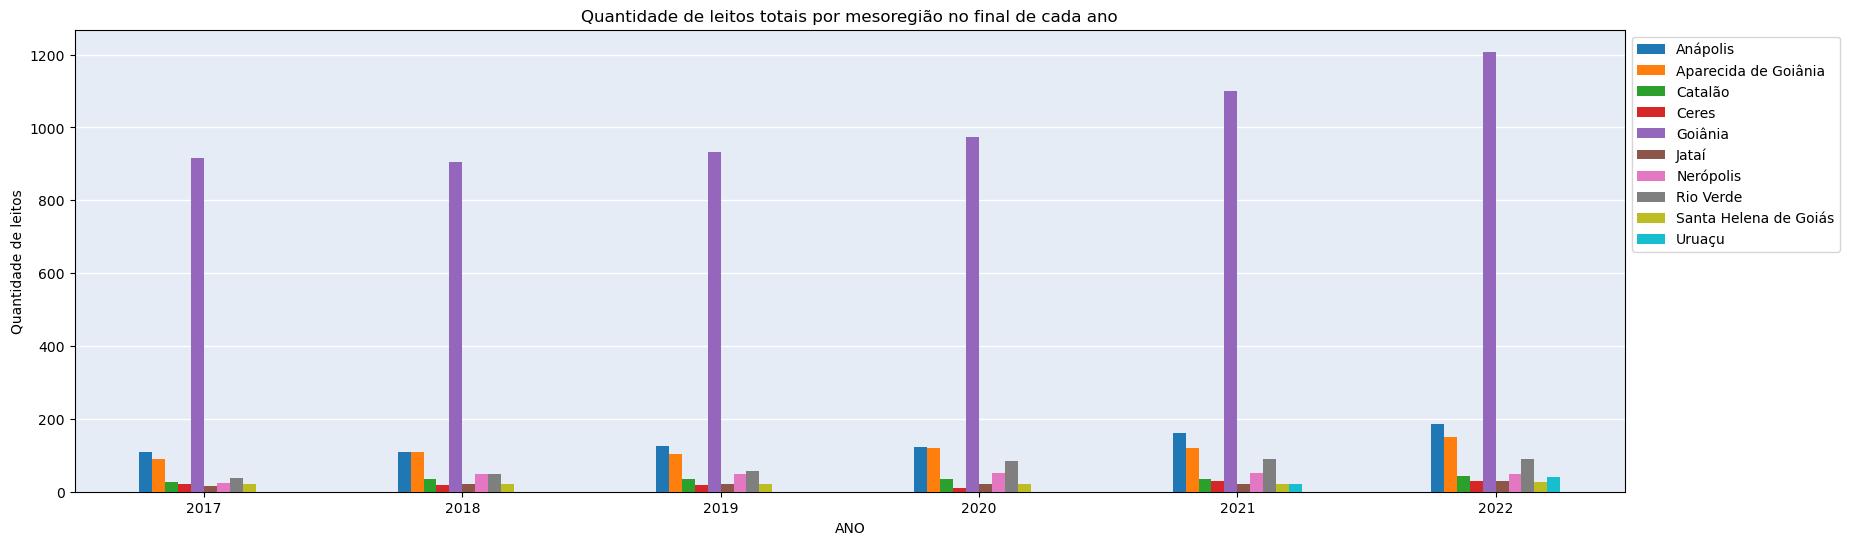

In [53]:
# data_for_bars = data_ultimo_mes_por_meso.groupby(["ANO", "MESOREGIAO"]).sum()[["QT_EXIST", "QT_SUS"]].reset_index()
data_for_bars = leitos_por_cidade_fim_ano.pivot(index="ANO", columns="NOME_MUNICIPIO", values="QT_EXIST")
pl = data_for_bars.plot(kind="bar", figsize=(20, 6), rot=0, ylabel="Quantidade de leitos", title="Quantidade de leitos totais por mesoregião no final de cada ano", zorder=3)

# set grid in the background
pl.grid(color="white", linestyle="-", linewidth=1, axis="y", zorder=0)
pl.set_facecolor("#e5ecf6")
pl.legend(loc='best', bbox_to_anchor=(1.0, 1.0))

## Conclusões acerca da quantidade de leitos de UTI em Goiás e o efeito da Pandemia de Covid-19

#### Observações no estudo de evolução da quantidade de leitos em Goiás
- Durante o período analisado (2017 a 2022), houve aumento expressivo de aproximadamente 53,2% na quantidade total de leitos em Goiás passando de 1.355 para 2.107 leitos. O Aumento no SUS foi de 39,8% durante todo o período, passando de 722 para 1.009 leitos. Portanto, durante esse período, o número de leitos não SUS aumentou proporcionalmente mais em quantidade em relação aos leitos SUS.
- A Pandemia foi oficialmente declarada pela OMS em março de 2020, quando o número de leitos em Goiás foi de 1.652 totais e 749 SUS. A partir de então houve um aumento de 27,6% na quantidade total de leitos de UTI em Goiás até Novembro de 2022. O Aumento no SUS foi de 34,7% durante o mesmo período. O aumento na quantidade absoluta de leitos de UTI foi, portanto, proporcionalmente maior dentre os Leitos do SUS do que os que dentre os que não são do SUS desde que foi decretada a Pandemia pela OMS.
- A quantidade máxima no número de leitos totais foi verificada em setembro de 2022 (2.115 leitos). Já No Sus, a quantidade máxima foi verificada a partir de março de 2021 (1.019 leitos). Isso significam aumentos percentuais de 28,0% e 36,0%, respectivamente, nos leitos totais e nos Leitos pelo SUS em relação a Março de 2020, quando foi decretada Pandemia pela OMS. Mais uma vez, nota-se no auge que os leitos de UTI SUS aumentaram proporcionalmente mais em quantidade em relação aos leitos de UTI não SUS desde que foi decretada a Pandemia pela OMS.

#### Observação no estudo de evolução da quantidade de leitos distribuído por Mesoregião
- Verifica-se, desde o início do estudo, grandes disparidades regionais na quantidade de leitos de UTI em Goiás. A Mesoregião Noroeste, por exemplo, possui apenas 0,5% da quantidade total de leitos em Goiás em novembro de 2022 (10 leitos), enquanto a Mesoregião Centro possui 80,1% da quantidade total de leitos em Goiás em novembro de 2022 (1.692 leitos). A Mesoregião Sul possui 14,4% da quantidade total de leitos em Goiás (303 leitos). A Mesoregião Leste possui 2,7% da quantidade total de leitos em Goiás (57 leitos). A Mesoregião Norte possui 2,4% da quantidade total de leitos em Goiás (50 leitos). Portanto, a maioria dos leitos totais se encontra em cidades localizadas na região Centro de Goiás, onde localizam-se cidades como Goiânia, Aparecida de Goiânia, Anápolis e Senador Canedo.
- No auge da quantidade de leitos totais, ocorrida em setembro de 2022, a Mesoregião Centro possuía 80,0% da quantidade total de leitos em Goiás (1.692 leitos), enquanto a Mesoregião Sul possuía 14,3% da quantidade total de leitos em Goiás (303 leitos). A Mesoregião Leste possuía 2,7% da quantidade total de leitos em Goiás (57 leitos). A Mesoregião Norte possuía 2,4% da quantidade total de leitos em Goiás (50 leitos). A região Noroeste possuía 0,5% do total de leitos em Goiás (10 leitos) Portanto, a maioria dos leitos totais se encontram em cidades localizadas na região Centro de Goiás, também no auge da Pandemia.
- Desde que foi decretada a Pandemia pelo OMS, em março de 2020, a Mesoregião Centro passou de 1.439 leitos totais de UTI para 1.692 leitos totais no auge da pandemia, um aumento de 17,6% (ou 253 novos leitos). Foi a região que mais ganhou leitos de UTI como consequência da Pandemia de Covd-19 em Goiás.

#### Observação no estudo de evolução da quantidade de leitos distribuído por Cidade
- Verifica-se que Goiânia é foi a cidade com maior quantidade de leitos durante todo o período analisado, seguida por Aparecida de Goiânia e Anápolis. Goiânia possuía 57,3% dos leitos totais de Goiás ao final do período de análise, enquanto anápolis aparecia com 8,9%, e aparecida de Goiânia possuía 7,1% do total. Destacam-se na quantidade total de leitos, além dessas três principais cidades: Catalão, Ceres, Rio Verde, Jataí, Nerópolis, Santa Helena de Goiás e Uruaçu.

# Conclusões Finais acerca da quantidade de leitos de UTI em Goiás e o efeito da Pandemia de Covid-19

- Concentração dos Leitos (tanto totais quanto de UTIs) na região Centro, seguida pela região sul do estado. Essas regiões são centralizadoras de recursos de saúde no Estado.
- A centralização se faz ainda mas forte em se tratando de Leitos de UTIs do que em relação aos leitos não UTIs. A concentração de recursos nessas localidades é percentualmente ainda mais intensa.
- Um efeito interessante é que a quantidade de Leitos Totais teve um auge em meados da pandemia, depois iniciou uma pequena queda, ainda mantendo-se em patamares superiores aos vistos antes da Pandemia.
- Em se tratando de Leitos de UTI, a quantidade seguiu uma lógica parecida: hoje temos mais UTIs do que antes da Pandemia. Mas aqui um detalhe interessante: a quantidade de UTIs se mantém hoje praticamente a mesma que durante o Auge da Pandemia de 2019. Portanto, não houve redução significativa da quantidade de UTIs após o auge da Pandemia. Isso pode ser apontado como um efeito mais duradouro das melhorias de saúde providas para enfrentamento à pandemia em se tratando de leitos de UTI.
- As melhorias verificadas são duradouras e portanto benéficas para a populaçÃO residente aqui no Estado, bem como para populações de outros estados que vem procurar tratamento médico em Goiás. Mantendo nossa referência nacional em Medicina e Saúde. Isso mesmo após a redução nos níveis de infecção por COVID-19.